In [1]:
# =====================
# Imports
# =====================
%load_ext line_profiler

from geocert import compute_boundary_batch, batch_GeoCert, incremental_GeoCert
import geocert_oop as geo
from plnn import PLNN
import _polytope_ as _poly_
from _polytope_ import Polytope, Face, from_polytope_dict
import utilities as utils
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
# from convex_adversarial import robust_loss


import sys
sys.path.append('mister_ed')


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [2]:
import mister_ed.adversarial_attacks as aa

In [3]:
# apply incremental geocert to a normal and l1-regularized classifier. Finds maximal l_p balls
# for random points in R^2.

# ==================================
# Generate Training Points
# ==================================

print('===============Generating Training Points============')
# random points at least 2r apart
m = 12
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

print('===============Points Generated============')

===============Generating Training Points============
===============Points Generated============


===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=10, bias=True)
  (6): ReLU()
  (7): Linear(in_features=10, out_features=2, bias=True)
)
===============Training Network with Regularization============
error:  tensor(0.)


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


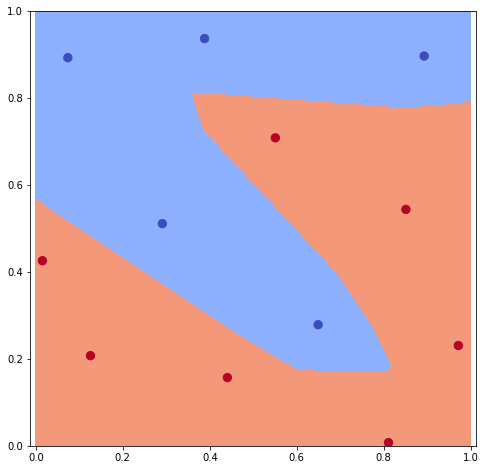

In [4]:
# ==================================
# Initialize Network
# ==================================

print('===============Initializing Network============')
network = PLNN([2, 10, 50, 10, 2])
net = network.net


# ==================================
# Train Network
# ==================================

def l1_loss(net):

    return sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])


print('===============Training Network with Regularization============')
opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y)).view([1])

    l1_scale = torch.Tensor([1e-4])
    l += l1_scale * l1_loss(net).view([1])

    err = (out.max(1)[1].data != y).float().mean()
    opt.zero_grad()
    (l).backward()
    opt.step()

print('error: ', err)



# ==================================
# Visualize:  regularized classifier boundary
# ==================================

XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = network(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()

_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0, 1, 0, 1])

plt.show()

In [5]:

save_dir = os.path.join(os.getcwd(), 'plots/oop_plnn_l2/')
geocert = geo.IncrementalGeoCert(network, verbose=True, display=True, save_dir=save_dir, 
                                 ax=None)


In [10]:
examples = torch.Tensor([[0.7, 0.6], 
                         [0.5, 0.5]])
labels = network(examples).max(1)[1]

print(examples)
print(labels)


tensor([[0.7000, 0.6000],
        [0.5000, 0.5000]])
tensor([1, 0])


In [11]:
import adversarial_perturbations as ap 
import prebuilt_loss_functions as plf
import loss_functions as lf 
import adversarial_attacks as aa
import utils.pytorch_utils as me_utils
from importlib import reload 
reload(aa)

<module 'adversarial_attacks' from 'mister_ed/adversarial_attacks.py'>

In [12]:
delta_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                 'lp_bound': 1.0})
normalizer = me_utils.IdentityNormalize() 
distance_fxn = lf.L2Regularization
carlini_loss = lf.CWLossF6
cwl2_attack = aa.CarliniWagner(net, normalizer, delta_threat, distance_fxn, carlini_loss)

attack_kwargs = {'warm_start': False, 'num_optim_steps': 2000, 'num_bin_search_steps': 5,
                 'initial_lambda': 10, 'verbose': True}
pert_out = cwl2_attack.attack(examples, labels, **attack_kwargs)
#adv_examples


DIST <class 'loss_functions.L2Regularization'> True <class 'loss_functions.ReferenceRegularizer'>
Starting binary_search_step 00...
Optim search: 100, Loss: tensor(61.4530, grad_fn=<ThAddBackward>)
(iteration 100):  100.0 correct
Optim search: 200, Loss: tensor(52.1420, grad_fn=<ThAddBackward>)
(iteration 200):  100.0 correct
Optim search: 300, Loss: tensor(42.8309, grad_fn=<ThAddBackward>)
(iteration 300):  100.0 correct
Optim search: 400, Loss: tensor(33.5200, grad_fn=<ThAddBackward>)
(iteration 400):  100.0 correct
Optim search: 500, Loss: tensor(24.2092, grad_fn=<ThAddBackward>)
(iteration 500):  100.0 correct
Optim search: 600, Loss: tensor(19.3355, grad_fn=<ThAddBackward>)
(iteration 600):  50.0 correct
Optim search: 700, Loss: tensor(14.6799, grad_fn=<ThAddBackward>)
(iteration 700):  50.0 correct
Optim search: 800, Loss: tensor(10.0243, grad_fn=<ThAddBackward>)
(iteration 800):  50.0 correct
Optim search: 900, Loss: tensor(5.3687, grad_fn=<ThAddBackward>)
(iteration 900):  50.0

In [15]:
pert_out.adversarial_tensors()

tensor([[0.5985, 0.4985],
        [0.5506, 0.5505]])